In [1]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
from IPython.display import display, JSON, clear_output

In [2]:
from EventReader import EventReader
from EventReader import show_data

#### Check all available data

In [3]:
data_dir = '/data/xenon/acolijn/optosim/data/'
show_data(data_dir)

File /data/xenon/acolijn/optosim/data/mc0003/mc0003.0000.hd5f is currently open by another process. Skipping...


,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0004,XAMS,10000,10000,False,True,3.2
4,mc0005,XAMS,10000,10000,True,True,3.2
5,mc9999,XAMS,100,10000,False,True,8.0


#### Get all the file names and initialize the data reader class

In [4]:
files = glob.glob('/data/xenon/acolijn/optosim/data/mc0001/*0000.hd5f')
events = EventReader(files)

number of files:  1


#### Loop over the events

In [16]:
%%time
n = 0
nmax =10000 # if you do not want to loop over all events

xp = []
yp = []
q_tb = []
q_lr = []
q_tot = []

for ev in events:
    if n%1000 == 0:
        print('processed ',n,'events')#, events.print_event(ev))
    n+=1
    
    # retrieve the true hit position
    x_true = ev['true_position'][()]
    xp.append(x_true[0])
    yp.append(x_true[1])
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    qtot = float(np.sum(pmt))
    q_tb.append((pmt[0][0]+pmt[1][0])/qtot)
    q_lr.append((pmt[0][0]+pmt[0][1])/qtot)
    q_tot.append(qtot)
            
    # and the other data if you like....
    fine_top = ev['fine_top'][()]
    pmt_bot = ev['pmt_bot'][()]
    fine_bot = ev['fine_bot'][()]
    
    if n>nmax:
        break

events.reset()

processed  0 events
CPU times: user 127 ms, sys: 6.72 ms, total: 134 ms
Wall time: 146 ms


#### Plot the charge ratio

Two plots: (i) $Q_L / Q_{tot}$ as a function of $x$ (ii) $Q_B / Q_{tot}$ as a function of $y$.

Text(0, 0.5, '$Q_B / Q_{tot}$')

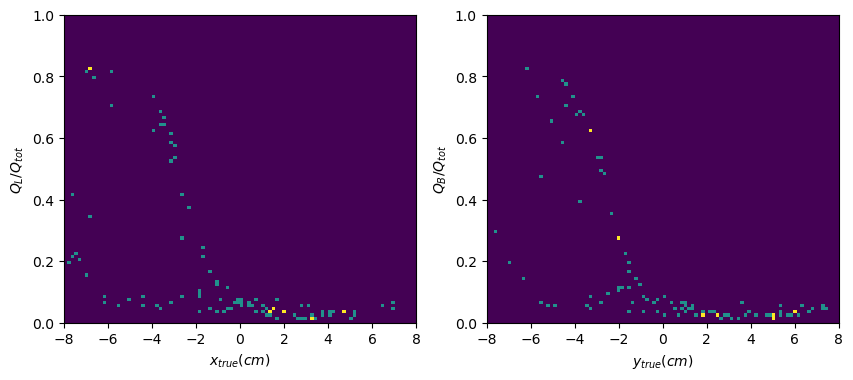

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(xp,q_lr,bins=(100,100), range=((-R,R),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(yp,q_tb,bins=(100,100), range=((-R,R),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')

.... and also $Q_{tot}$ as a function of radius.

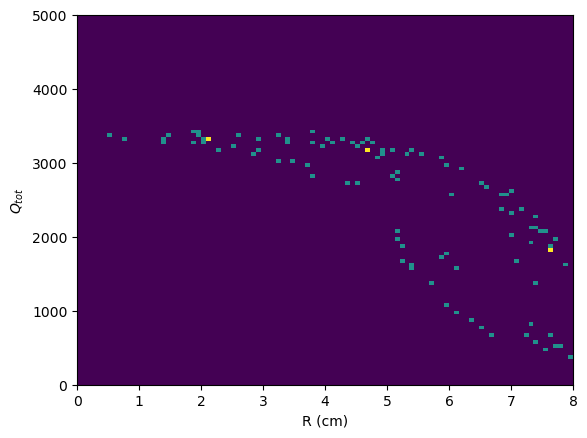

In [18]:
xp = np.array(xp)
yp = np.array(yp)
R = events.config['geometry']['radius']


q_tot = np.array(q_tot)
r2 = np.sqrt(xp**2+yp**2)
h=plt.hist2d(r2,q_tot,bins=100, range=((0,R),(0,5000)))
plt.xlabel('R (cm)')
plt.ylabel('$Q_{tot}$')
plt.show()

#### Event display

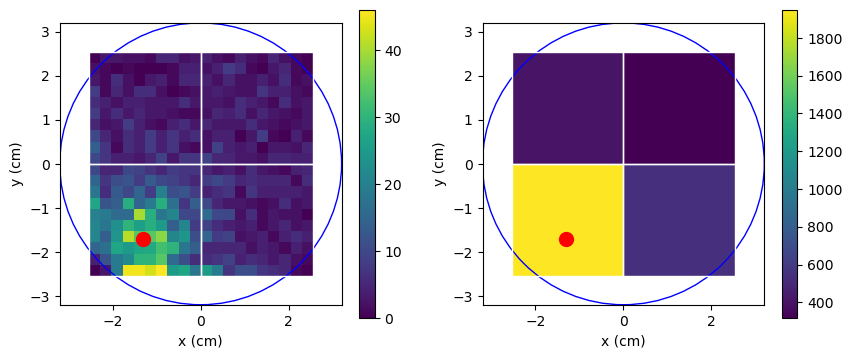

[-1.30884328 -1.7012954   0.1       ]
Press Enter to continue to the next event or 'q' to quit...q
Quit the event display......


In [5]:
events = EventReader(files)

for ev in events:
    events.show_event(ev)

    print(ev['true_position'])
    response = input("Press Enter to continue to the next event or 'q' to quit...")

    if response.lower() == 'q':
        print("Quit the event display......")
        break
        
    clear_output(wait=True)

events.reset()

#### Little hack to add attributes to the hd5f files..... be careful!


In [ ]:
filename='/data/xenon/acolijn/optosim/data/mc0005/mc0005.0000.hd5f'

filename='xxxxxx' # just for safety
with h5py.File(filename, 'r+') as f:
    config_str = f.attrs['config']
    config_dict = json.loads(config_str)  # Parse the string to get a dictionary
    config_dict['detector'] = 'XAMS'
    modified_config_str = json.dumps(config_dict)  # Convert the modified dictionary back to a string
    f.attrs['config'] = modified_config_str


In [9]:
events.close()

In [6]:
int(-0.1/2.)

0